In [44]:
%load_ext autoreload
%autoreload 2
import math
from matplotlib import pyplot as plt
from train_box_model import initialize_model_and_state
from jax.random import PRNGKey, split
from box_model import make_box, rot_axis_to_quaternion, draw_box, overimpose_point_cloud, simulate, draw_box_no_bar
from jax import numpy as jnp
from jax import vmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
m, tx, opt_state, params, state = initialize_model_and_state(
        key=PRNGKey(1574),
        obs_length=100,
        lr=1e-4,
        num_input_vars=3,
        load_idx=1,
        chkpt_folder="box_chkpts_flow_beta_00/",
        deterministic = True,
    )

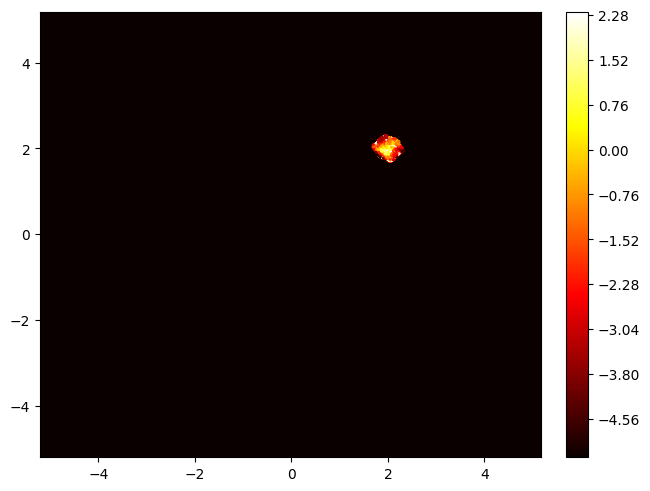

In [89]:
hx=.2
hy=.2
hz=.2
q=rot_axis_to_quaternion(jnp.array([1,1,1.0])/3**0.5,jnp.array(1.001))
# hx,hy,hz = 1.0361311 ,  0.84753823,  0.21451688,
# q = jnp.array([0.24576879, -0.41609514, 0.0858047 ,  0.5095999])
# qn = jnp.linalg.norm(q)
# q /= qn
t=jnp.array([2.,2,2])
latents = jnp.concatenate([jnp.stack([hx, hy, hz]), t, q])
pc, box = simulate(PRNGKey(0), latents, obs_noise_std=0.03, num_points=200)
ax,fig = draw_box(box)
overimpose_point_cloud(fig, ax, pc)

In [90]:
num_samples = 25
my_sample = vmap(lambda k: m.apply(
    {"params": params, **state},
            pc[None],
            latents[None],
            rngs={"rsample_key": k,},)[1][0])
s = my_sample(split(PRNGKey(0),num_samples))

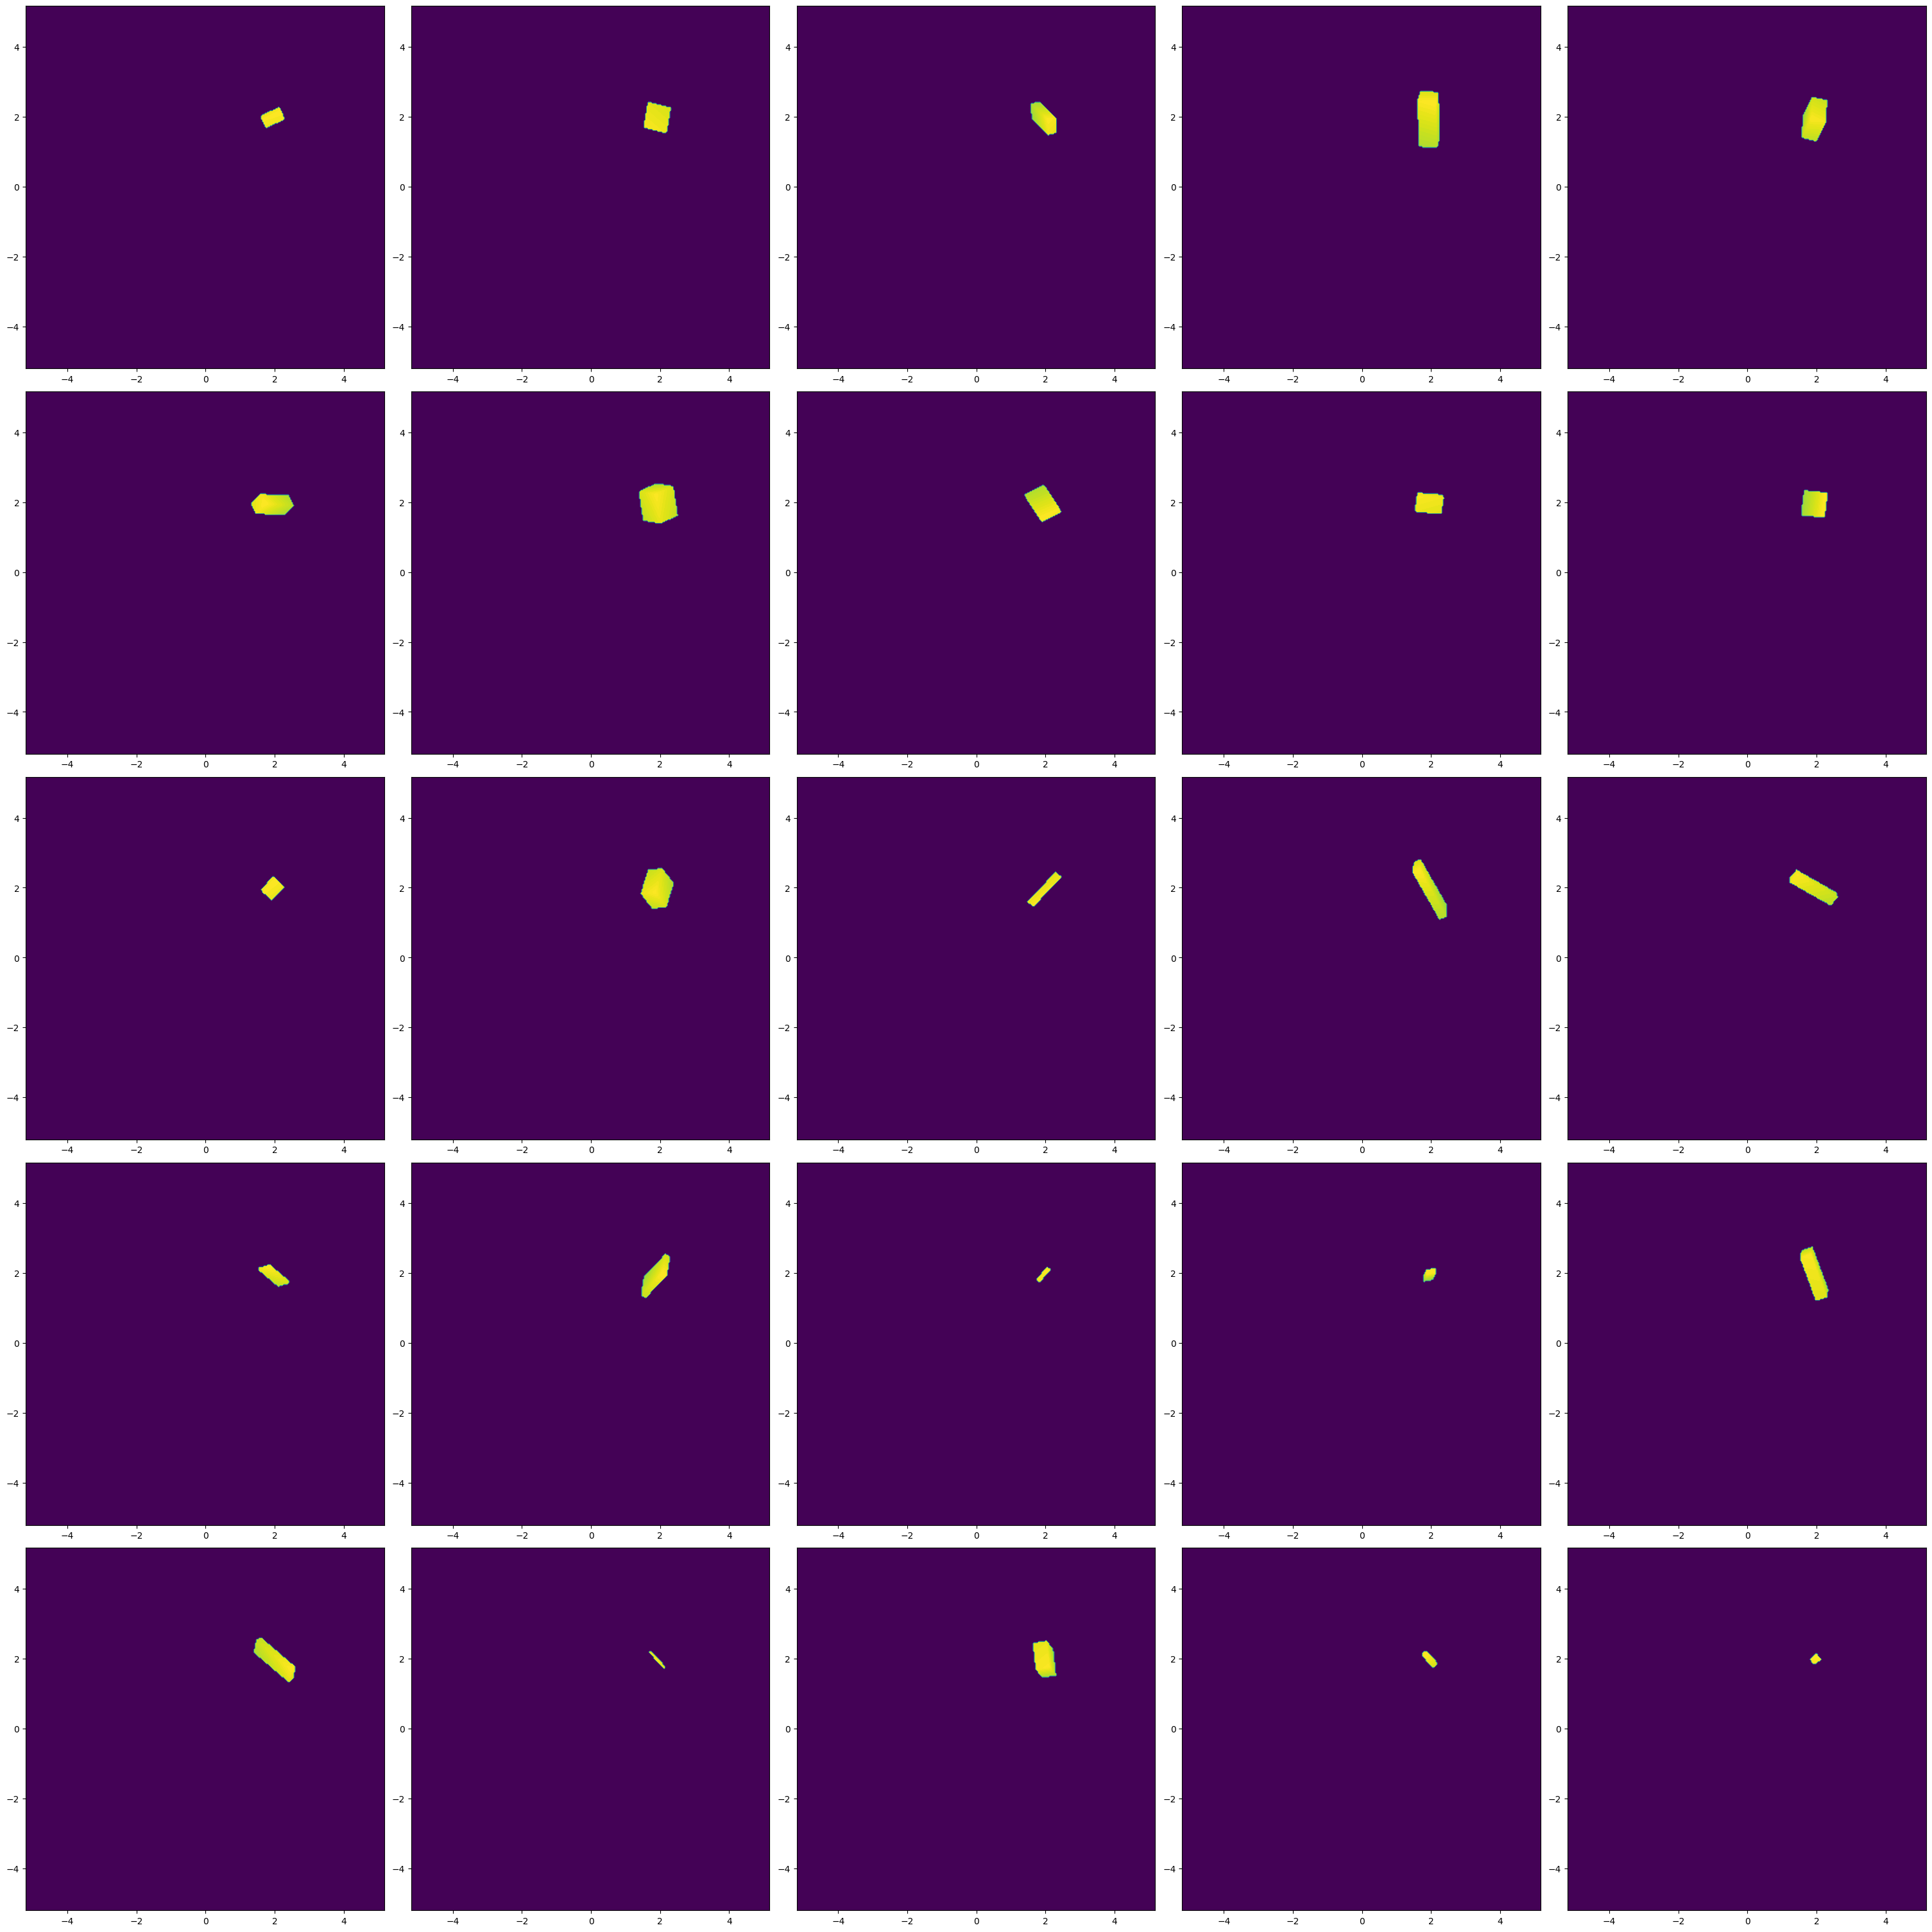

In [91]:
num_plots = num_samples
num_cols = 5
num_rows = math.ceil(num_plots/num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30,30), constrained_layout=True)

for i in range(num_plots):
    c = i % num_cols
    r = math.floor(i/num_cols)
    hx, hy, hz = s[i,:3]
    t = s[i,3:6]
    q = s[i,6:]
    qn = jnp.linalg.norm(q)
    q/=qn
    box = make_box(hx, hy, hz, t, q)
    draw_box_no_bar(box, axes[r,c])